## Requirements

The following python libs are required to run this notebook:

### Core audio processing
- librosa==0.10.1  
- praat-parselmouth==0.4.3  
- soundfile==0.12.1  
- ffmpeg-python==0.2.0  

### Transcription
- openai-whisper==20231116  

### NLP and similarity analysis
- spacy==3.7.2  
- scikit-learn==1.3.2  
- numpy==1.26.4  

### Visualization
- matplotlib==3.8.3  
- seaborn==0.13.2  

### General utilities
- pandas==2.2.1  
- scipy==1.12.0  
- tqdm==4.66.2  

### FFmpeg is also required for audio handling.
- Windows(with chocolatey):`choco install ffmpeg`

### Additional setup
After installing `spacy`, download the required language model:
python -m spacy download en_core_web_md


In [ ]:
%pip install openai-whisper
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118


In [ ]:
import whisper
import os
import pandas as pd

model = whisper.load_model("base")
audio_folder = "audio_wav" #please change this to wherever your files would be stored ehile evaluating
transcripts =[]

for filename in sorted(os.listdir(audio_folder)):
    if filename.endswith(".wav"):
        path=os.path.join(audio_folder, filename)
        result=model.transcribe(path)
        text=result["text"]
        transcripts.append({"filename": filename, "transcript": text})
        print(f"{filename} → {text}")               
df=pd.DataFrame(transcripts)
df.to_csv("transcripts_whisper.csv",index=False)


Recording (1).wav →  Yesterday I went to the market to buy some apples I think but I forgot why I went there in the first place.
Recording (10).wav →  Let me think, let me think. I know this one. It's on the tip of my tongue. Wait, no it's gone.
Recording (11).wav →  First I brush my teeth, then I take a shower. After that I make breakfast or Stroke my phone I guess
Recording (12).wav →  If I had to cook pasta, the first thing I do is boil water or wait. Do I add salt first?
Recording (13).wav →  Today is Wednesday or maybe Thursday. I'm not really sure anymore.
Recording (14).wav →  I remember my childhood friend's name was Rivi or maybe it was Rakesh.
Recording (15).wav →  I drink tea every morning because it makes me feel calm. Yeah calm and focused.
Recording (16).wav →  When I hear the word hospital, I think of doctors, nurses and...
Recording (17).wav →  Every morning I get up and I wait.
Recording (18).wav →  I went to brush my teeth with a fork. I mean brush.
Recording (19).wav

In [ ]:
import os
import pandas as pd
import librosa
import numpy as np
import re

#Loadtranscript CSV
transcript_df=pd.read_csv("transcripts_whisper.csv")
audio_folder="audio_wav"

#Hesitation detection function
def count_hesitations(text):
    #Mtching common hesitation words
    pattern= r"\b(um+|uh+|uhm+|erm+|hmm+)\b"
    return len(re.findall(pattern, text.lower()))
# Feature extraction
features=[]
for index, row in transcript_df.iterrows():
    filename=row['filename']
    text=row['transcript']
    path=os.path.join(audio_folder, filename)
    
    try:
        y, sr =librosa.load(path)
        duration=librosa.get_duration(y=y, sr=sr)

        #Pitch variabili ty
        pitches=librosa.yin(y, fmin=50, fmax=300)
        pitch_std=np.std(pitches)

        #pause detect
        intervals=librosa.effects.split(y, top_db=25)
        pauses=0
        for i in range(1,len(intervals)):
            gap= (intervals[i][0] - intervals[i-1][1]) / sr
            if gap>0.3:
                pauses +=1

        #Words per second
        word_count=len(text.split())
        speech_rate=word_count / duration if duration > 0 else 0

        #Hesitation count
        hesitations=count_hesitations(text)

        #saving
        features.append({
            "filename": filename,
            "duration_sec": duration,
            "speech_rate": speech_rate,
            "num_pauses": pauses,
            "pitch_variation": pitch_std,
            "num_hesitations": hesitations
        })
        #bad case 
    except Exception as e:
        print(f"Error processing {filename}: {e}")

#save features
feature_df = pd.DataFrame(features)
feature_df.to_csv("features.csv", index=False)
feature_df.head(10)


,filename,duration_sec,speech_rate,num_pauses,pitch_variation,num_hesitations
0,Recording (1).wav,12.600000,1.984127,3,65.465446,2
1,Recording (10).wav,9.048027,2.320948,3,73.419755,0
2,Recording (11).wav,10.680000,2.059925,1,67.798346,1
3,Recording (12).wav,11.016009,1.997093,4,70.478419,1
4,Recording (13).wav,9.144036,1.312331,3,81.372433,1
5,Recording (14).wav,9.384036,1.598459,3,70.006817,2
6,Recording (15).wav,8.472018,1.888570,2,74.063992,1
7,Recording (16).wav,12.000000,1.333333,2,79.360025,1
8,Recording (17).wav,10.056009,0.994430,2,83.004802,1
9,Recording (18).wav,7.464036,1.741685,1,79.774998,1


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

df=pd.read_csv("features.csv")
X=df[["speech_rate", "num_pauses", "pitch_variation", "num_hesitations"]]

#Normalize
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

#Clustering with KMeans
kmeans=KMeans(n_clusters=2,random_state=42,n_init=10)
df['kmeans_cluster']=kmeans.fit_predict(X_scaled)

#Anomaly detection with Isolation Forest
iso=IsolationForest(contamination=0.2, random_state=42)
df["anomaly_score"]=iso.fit_predict(X_scaled)
df["is_at_risk"]=df["anomaly_score"].apply(lambda x: 1 if x == -1 else 0)

df.to_csv("features_with_risk.csv", index=False)
#Show flagged risky samples
print(df[df["is_at_risk"] == 1][["filename", "speech_rate", "num_pauses", "num_hesitations", "pitch_variation"]])


              filename  speech_rate  num_pauses  num_hesitations  \
0    Recording (1).wav     1.984127           3                2   
1   Recording (10).wav     2.320948           3                0   
10  Recording (19).wav     1.174810           5                2   
11   Recording (2).wav     1.421692           3                0   

    pitch_variation  
0         65.465446  
1         73.419755  
10        74.615726  
11        80.079454  


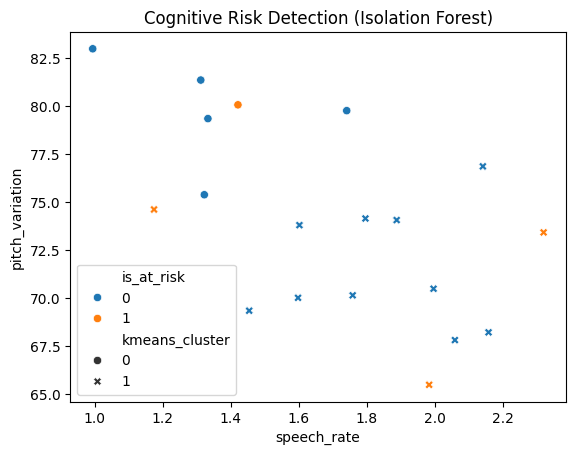

In [ ]:
sns.scatterplot(data=df, x="speech_rate", y="pitch_variation", hue="is_at_risk", style="kmeans_cluster")
plt.title("Cognitive Risk Detection (Isolation Forest)")
plt.show()

C:\Users\archi\AppData\Local\Temp\ipykernel_31096\1095092947.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="filename",y="speech_rate",data=df,palette="Blues_d")


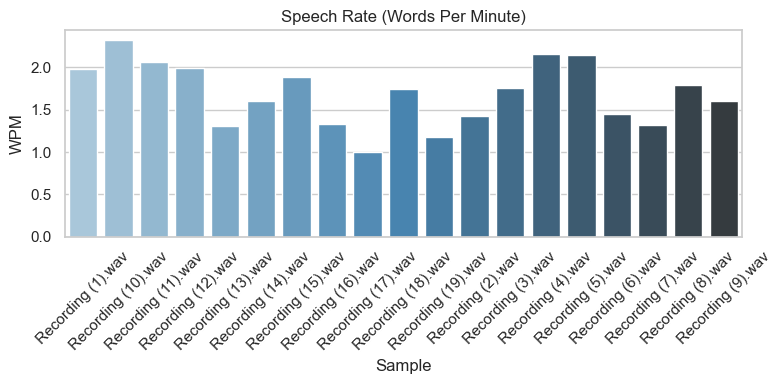

C:\Users\archi\AppData\Local\Temp\ipykernel_31096\1095092947.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="filename",y="num_hesitations",data=df,palette="Reds")


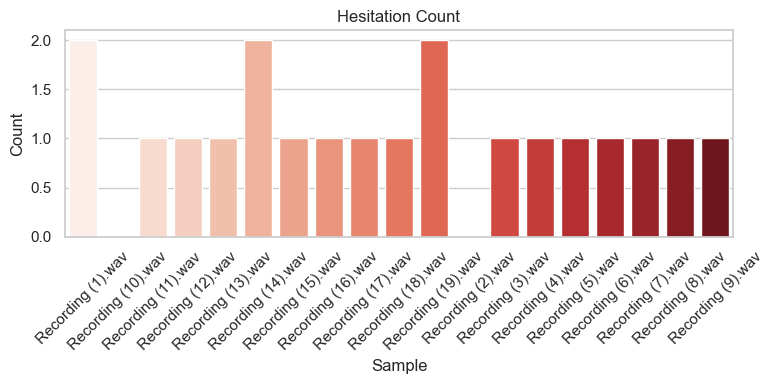

C:\Users\archi\AppData\Local\Temp\ipykernel_31096\1095092947.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="filename",y="pitch_variation",data=df,palette="Purples")


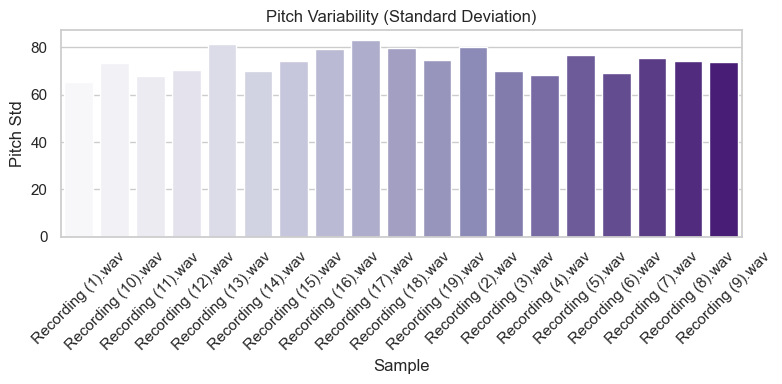

C:\Users\archi\AppData\Local\Temp\ipykernel_31096\1095092947.py:39: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="filename",y="num_pauses",data=df,palette="Greens")


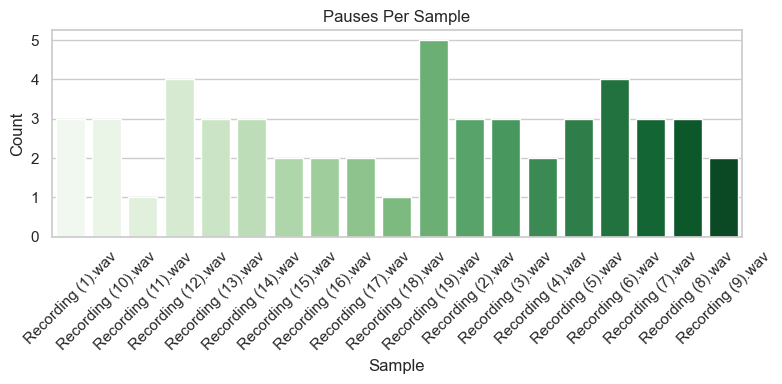

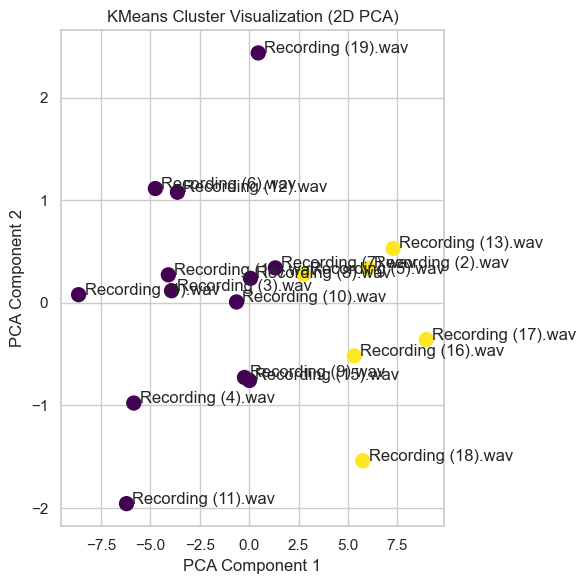

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import pandas as pd

df=pd.read_csv("features_with_risk.csv")

sns.set(style="whitegrid")

plt.figure(figsize=(8,4))
sns.barplot(x="filename",y="speech_rate",data=df,palette="Blues_d")
plt.title("Speech Rate (Words Per Minute)")
plt.ylabel("WPM")
plt.xlabel("Sample")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x="filename",y="num_hesitations",data=df,palette="Reds")
plt.title("Hesitation Count")
plt.ylabel("Count")
plt.xlabel("Sample")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x="filename",y="pitch_variation",data=df,palette="Purples")
plt.title("Pitch Variability (Standard Deviation)")
plt.ylabel("Pitch Std")
plt.xlabel("Sample")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.barplot(x="filename",y="num_pauses",data=df,palette="Greens")
plt.title("Pauses Per Sample")
plt.ylabel("Count")
plt.xlabel("Sample")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

features=df[["speech_rate","num_pauses","pitch_variation","num_hesitations"]]
kmeans=KMeans(n_clusters=2,random_state=0).fit(features)
pca=PCA(n_components=2)
components=pca.fit_transform(features)

plt.figure(figsize=(6,6))
plt.scatter(components[:,0],components[:,1],c=kmeans.labels_,cmap="viridis",s=100)
for i,txt in enumerate(df["filename"]):
    plt.annotate(txt,(components[i,0]+0.3,components[i,1]))
plt.title("KMeans Cluster Visualization (2D PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.tight_layout()
plt.show()
